In [1]:
import os
import sys
import numpy as np
import time
# import pyaudio
import wave
import zipfile
import wavio
import random
# import asyncio
import IPython
from IPython.display import Audio
# from queue import Queue
# from threading import Thread
import argparse
import array
import audioop
np.set_printoptions(threshold=sys.maxsize)

In [2]:
# import sounddevice as sd
# import soundfile as sf
# import scipy

In [3]:
import tensorflow as tf

2024-07-05 10:46:21.159688: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-05 10:46:21.180309: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-05 10:46:21.180333: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-05 10:46:21.181028: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-05 10:46:21.184794: I tensorflow/core/platform/cpu_feature_guar

In [4]:
import matplotlib.pyplot as plt

In [5]:
sys.path.append("../../../src/")
sys.path.append("../")
sys.path.append("../../");
# sys.path.append("../../src/SharedLibs/")

In [6]:
from common import utils as U
from TestSharedLib.bytes import to_bytes, from_bytes, byte_conversion_tests, load_data, load_raw, save_raw, save_scores
from TestSharedLib.constants import quant_support, crops, feature_count
# from Libs.SharedLibs import getFileList;
from SharedLibs.sys_untity import getFileList
# from data_processing_utility import save_wavefile

## shared utility codes

In [7]:
from datetime import datetime
def genDataTimeStr():
    return datetime.today().strftime('%Y-%m-%d %H:%M:%S').replace('-',"").replace(' ',"").replace(':',"");

In [8]:
def plot_wav(wavsig):
    plt.plot(wavsig)
    plt.ylabel("Amplitude")
    plt.xlabel("Time")
    plt.show()

In [9]:
"""
np.pad(sig, pad_length//2, 'constant'):
會在sig二端各pad長度為pad_length//2的值，值預設為0
np.pad(sig, (0,pad_length), 'constant')
會在sig的尾端pad值，值預設為0
"""
def padding_sig(sig, pad_length):
    sig = np.pad(sig, (0,pad_length), 'constant')
    return sig

In [10]:
# model_path = "../../trained_models/step_1_base_train/tflite_model/uec_model_4Classes_20240520150535.tflite";
# model_path = "../../trained_models/step_1_base_train/tflite_model/uec_model_4C_val80tracc89_onesecond_20240621104432.tflite"
model_path = "../../../trained_models/step_1_base_train/tflite_model/uec_model_4C_val80tracc89_onesecond_20240621104432.tflite"
tflite_interpreter = tf.lite.Interpreter(model_path=model_path)

In [11]:
# model.summary()
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])
tflite_interpreter.allocate_tensors();

== Input details ==
name: x.3
shape: [    1     1 20150     1]
type: <class 'numpy.float32'>

== Output details ==
name: 285
shape: [1 4]
type: <class 'numpy.float32'>


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


### sound preprocessing codes

In [12]:
_inputLen = 20150
_nCrops = 2
def preprocess_setup():
    funcs = []
    funcs += [U.padding( _inputLen// 2), #這裏是前後pad _inputLen//2長度的資料
              U.normalize(32768.0),
              U.multi_crop(_inputLen, _nCrops)]
              # U.single_crop(_inputLen)]
              # 

    return funcs

def preprocess_debug():
    debug_funcs = []
    debug_funcs += [U.padding( _inputLen// 2),
              # U.normalize(32768.0),]
              U.multi_crop(_inputLen, _nCrops)]
              # U.single_crop(_inputLen)]
    return debug_funcs

def preprocess_setup_padding2():
    funcs = []
    funcs += [U.padding((0, _inputLen)), #這裏是前後pad _inputLen//2長度的資料
              U.normalize(32768.0),
              U.multi_crop(_inputLen, _nCrops)]
              # U.single_crop(_inputLen)]
              # 

    return funcs



def preprocess(sound, funcs):
    for f in funcs:
        sound = f(sound)
    return sound;
    

def padding(pad):
    def f(sound):
        return np.pad(sound, pad, 'constant')

    return f
    

# def random_crop(size):
#     def f(sound):
#         org_size = len(sound)
#         start = random.randint(0, org_size - size)
#         return sound[start: start + size]

#     return f



In [13]:
# _funcs = preprocess_debug()
_funcs = preprocess_setup()
# _funcs = preprocess_setup_padding2()

In [14]:
def doSoundClassification(sound=None, lblidx=None, channelIdx=0, ifSrc=1):
    start = 0;
    end = 0;
    if ifSrc == 1:
        start = sound.nonzero()[0].min();
        end = sound.nonzero()[0].max();
        sound = sound[start: end + 1];
    # if len(sound)> 220500:
    #     sound = sound[:220500]
    if len(sound)> 20150:
        sound = sound[:20151]
    # sound = np.int16(preprocess(sound, _funcs));
    sound = preprocess(sound, _funcs)
    s_test = np.expand_dims(sound[channelIdx], axis=0)
    s_test = np.expand_dims(s_test, axis=1);
    s_test = np.expand_dims(s_test, axis=3);
    
    tflite_interpreter.set_tensor(input_details[0]['index'], s_test);
    tflite_interpreter.invoke()
    pred = tflite_interpreter.get_tensor(output_details[0]['index'])
    pred_value = pred[0].argmax(axis=0)
    print(f"the largest value index is:{pred_value}");
    print(f"ALL Prediction Result: {pred}");
    # print(f"Prediction result: {pred}, and true label idx: {lblidx}")
    return pred_value

In [15]:
def endpoint_detection1(src_signal=None, test_seg_len=2000, threshod=500):
    src_signal_len = len(src_signal)
    current_volume_sum = float(0);
    loopnum = (src_signal_len // test_seg_len)-1; #consider drop out the remaining part
    # detect_value_list = [];
    detected_pos = 0;
    for i in range(loopnum):
        start_pos = i*test_seg_len;
        end_pos = (i+1)*test_seg_len;
        test_seg = src_signal[start_pos:end_pos];
        # energy = int(-(np.sqrt(np.mean(test_seg^2))));##-(np.sqrt(np.mean(test_seg**2)));
        energy = -audioop.rms(test_seg, 2)
        energy_bytes = bytes([energy & 0xFF, (energy >> 8) & 0xFF]);# shift energy right 8 bits and put it in high positions
        # print(f"len of test_seg:{len(test_seg)}, bytes seg:{len(energy_bytes * (len(test_seg)//2))}")
        debiased_energy = audioop.rms(audioop.add(test_seg, energy_bytes * len(test_seg), 2),2)
        if debiased_energy < threshod:
            detected_pos = end_pos;
        else:
            if debiased_energy > threshod:
                detected_pos = start_pos;
                return detected_pos
        # detect_value_list.append(debiased_energy);
    return detected_pos

In [132]:
test_alarm_wav = "../../datasets/CurrentUse/wav_files/Single_Fold/val/positive/alarm_52/155251_p_3.wav"
test_help_eng_wav = "../Eng_Help_Processed_Test_Sounds/test_man_eng_help_001.wav"
test_help_eng_wav2 = "../../datasets/CurrentUse/wav_files/Single_Fold/val/positive/help_eng_71/s2_extend_to_30225_repeat_help/man_clear_clip_help_032_71_sigrep.wav"
head_silence_help_eng_wav1 = "../../datasets/CurrentUse/wav_files/src_wavs/positive/help/help_english_71/s2_processed_30225_no_repeat/tail/man_clear_clip_help_006_71_tail.wav"
head_silence_wav_file2 = "../../datasets/CurrentUse/wav_files/src_wavs/positive/help/help_english_71/s2_processed_30225_no_repeat/tail/man_clear_clip_help_008_71_tail.wav";

In [133]:
IPython.display.display(Audio(head_silence_help_eng_wav1))

original wav waveform


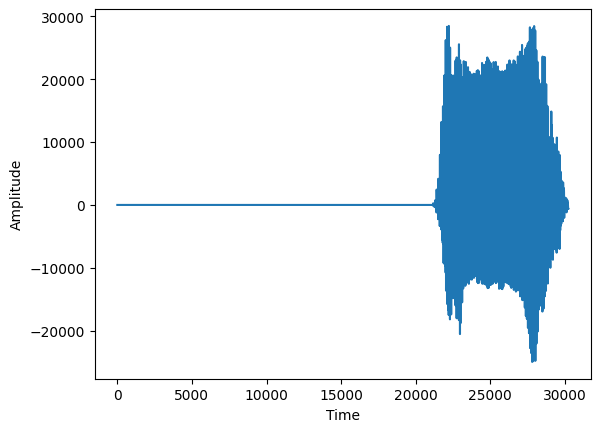

30225
silence_endpos:21200
padding_len:21200
trimed_sig len:9025


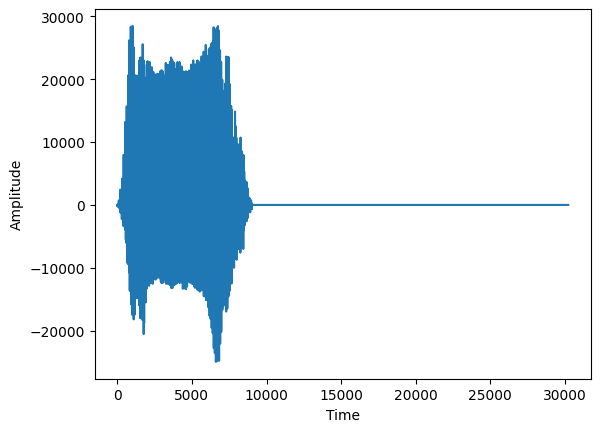

30225


In [135]:
print("original wav waveform")
original_head_silence_sig = wavio.read(head_silence_wav_file2).data.T[0]
plot_wav(original_head_silence_sig)
print(len(original_head_silence_sig))
silence_endpos = endpoint_detection1(original_head_silence_sig,test_seg_len=200)
print(f"silence_endpos:{silence_endpos}")
trimed_sig = original_head_silence_sig[silence_endpos:]
padding_len = len(original_head_silence_sig) - len(trimed_sig)
print(f"padding_len:{padding_len}")
print(f"trimed_sig len:{len(trimed_sig)}")
padded_sig = padding_sig(trimed_sig, padding_len)
plot_wav(padded_sig)
print(len(padded_sig))

# Batch Test

## tail english help

In [17]:
def test_help_with_endpoint1(help_eng_wav_dir=None):
    help_eng_list = getFileList(srcDir=help_eng_wav_dir);
    total_files = len(help_eng_list);
    print(f"total files:{total_files}");
    ground_truth = 2;
    src_counter = 0;
    trimmed_counter = 0;
    for f in help_eng_list:
        src_head_silence_sig = wavio.read(f).data.T[0]; #read original wav file
        trim_start_pos = endpoint_detection1(src_head_silence_sig,test_seg_len=200);
        src_head_silence_sig_f32 =  src_head_silence_sig.astype(np.float32);
        trimmed_wav_sig = src_head_silence_sig_f32[trim_start_pos:];
        padding_len = len(src_head_silence_sig_f32) - len(trimmed_wav_sig)
        trimmed_wav_sig = padding_sig(trimmed_wav_sig, padding_len)
        src_output = doSoundClassification(sound=src_head_silence_sig_f32, lblidx=ground_truth, channelIdx=0,ifSrc=1);
        trimmed_output = doSoundClassification(sound=trimmed_wav_sig, lblidx=ground_truth, channelIdx=0, ifSrc=2);
        print(f"ground_truth:{ground_truth}, src_output:{src_output}, trimmed_output:{trimmed_output}");
        if src_counter == ground_truth:
            src_counter+=1;
        if trimmed_output == ground_truth:
            trimmed_counter += 1;
    print(f"original wav files test accuracy:{(src_counter/total_files)*100}%");
    print(f"trimmed wav files test accuracy:{(trimmed_counter/total_files)*100}%")

In [23]:
help_wav_dir_tail = "../../datasets/CurrentUse/wav_files/src_wavs/positive/help/help_english_71/s2_processed_30225_no_repeat/tail/"
test_help_with_endpoint1(help_eng_wav_dir=help_wav_dir_tail)

## test moaning sounds

In [16]:
# the following codes are to show the wav files wavforms for selecting test sounds
# val_moaning_dir = "../../../datasets/CurrentUse/wav_files/Single_Fold/val/positive/moaning_56/"
# val_moaning_list = getFileList(val_moaning_dir)
# len_of_moaning_list = len(val_moaning_list)
# peek_range = int(len_of_moaning_list)
# for i in range(peek_range):
#     print(val_moaning_list[i])
#     sig = wavio.read(val_moaning_list[i]).data.T[0];
#     plot_wav(sig)
"""
selected moaning sounds for test
having silence in the head
../../../datasets/CurrentUse/wav_files/Single_Fold/val/positive/moaning_56/man_moaning_48_val_56.wav (fail)
../../../datasets/CurrentUse/wav_files/Single_Fold/val/positive/moaning_56/man_moaning_47_val_56.wav (work)
../../../datasets/CurrentUse/wav_files/Single_Fold/val/positive/moaning_56/0V9J_14_2_1_26_0_0_0_delaySpeech0.8_56.wav(work)
no silence in the head
../../../datasets/CurrentUse/wav_files/Single_Fold/val/positive/moaning_56/man_moaning_49_1_val_56.wav
../../../datasets/CurrentUse/wav_files/Single_Fold/val/positive/moaning_56/woman_moaning_38_val_56.wav
../../../datasets/CurrentUse/wav_files/Single_Fold/val/positive/moaning_56/man_moaning_39_val_56.wav
has short silence in the head
../../../datasets/CurrentUse/wav_files/Single_Fold/val/positive/moaning_56/woman_moaning_of_pain_31_1.wav
../../../datasets/CurrentUse/wav_files/Single_Fold/val/positive/moaning_56/woman_moaning_of_pain_28.wav
"""

'\nselected moaning sounds for test\nhaving silence in the head\n../../../datasets/CurrentUse/wav_files/Single_Fold/val/positive/moaning_56/man_moaning_48_val_56.wav (fail)\n../../../datasets/CurrentUse/wav_files/Single_Fold/val/positive/moaning_56/man_moaning_47_val_56.wav (work)\n../../../datasets/CurrentUse/wav_files/Single_Fold/val/positive/moaning_56/0V9J_14_2_1_26_0_0_0_delaySpeech0.8_56.wav(work)\nno silence in the head\n../../../datasets/CurrentUse/wav_files/Single_Fold/val/positive/moaning_56/man_moaning_49_1_val_56.wav\n../../../datasets/CurrentUse/wav_files/Single_Fold/val/positive/moaning_56/woman_moaning_38_val_56.wav\n../../../datasets/CurrentUse/wav_files/Single_Fold/val/positive/moaning_56/man_moaning_39_val_56.wav\nhas short silence in the head\n../../../datasets/CurrentUse/wav_files/Single_Fold/val/positive/moaning_56/woman_moaning_of_pain_31_1.wav\n../../../datasets/CurrentUse/wav_files/Single_Fold/val/positive/moaning_56/woman_moaning_of_pain_28.wav\n'

In [17]:
def test_moaning_with_endpoint1(moaning_wav_file=None):
    ground_truth = 1;
    src_counter = 0;
    trimmed_counter = 0;
    src_head_silence_sig = wavio.read(moaning_wav_file).data.T[0]; #read original wav file
    print("original moaning sound wavform")
    IPython.display.display(Audio(src_head_silence_sig,rate=20000))
    plot_wav(src_head_silence_sig)
    trim_start_pos = endpoint_detection1(src_head_silence_sig,test_seg_len=200);
    src_head_silence_sig_f32 =  src_head_silence_sig.astype(np.float32);
    trimmed_wav_sig = src_head_silence_sig_f32[trim_start_pos:];
    padding_len = len(src_head_silence_sig_f32) - len(trimmed_wav_sig)
    trimmed_wav_sig = padding_sig(trimmed_wav_sig, padding_len)
    print("after endpoint detect moaning sound wavform")
    IPython.display.display(Audio(trimmed_wav_sig,rate=20000))
    plot_wav(trimmed_wav_sig)
    print("<<Before endpoint detection result:>>")
    src_output = doSoundClassification(sound=src_head_silence_sig_f32, lblidx=ground_truth, channelIdx=0,ifSrc=1);
    print("======================================================================================")
    print("<<After endpoint detection result:>>")
    trimmed_output = doSoundClassification(sound=trimmed_wav_sig, lblidx=ground_truth, channelIdx=0, ifSrc=2);
    print("======================================================================================")
    print(f"ground_truth:{ground_truth} || original moaning predict:{src_output} || endpoint-detect moaning predict:{trimmed_output}");
    # if src_counter == ground_truth:
    #     src_counter+=1;
    # if trimmed_output == ground_truth:
    #     trimmed_counter += 1;
    # print(f"original wav files test accuracy:{(src_counter/total_files)*100}%");
    # print(f"trimmed wav files test accuracy:{(trimmed_counter/total_files)*100}%")

In [18]:
test_moaning_sounds_set2_headsilence_dir = "../../test_sounds/test_moaning_sounds_20240705/has_head_silence/"
test_moaning_sounds_set2_noheadsilence_dir = "../../test_sounds/test_moaning_sounds_20240705/no_head_silence/"
moaning_sounds_headsilence_list = getFileList(test_moaning_sounds_set2_headsilence_dir)
moaning_sounds_noheadsilence_list = getFileList(test_moaning_sounds_set2_noheadsilence_dir)

In [24]:
# for w in moaning_sounds_noheadsilence_list:
#     print(w)
"""
with head-silence
../../test_sounds/test_moaning_sounds_20240705/has_head_silence/man_moaning_dwn001_6_headsilence_56.wav (original:right, endpoint:wrong)
../../test_sounds/test_moaning_sounds_20240705/has_head_silence/man_moaning_dwn001_5_headsilence_56.wav (right_all)
../../test_sounds/test_moaning_sounds_20240705/has_head_silence/woman_moaning_dwn001_2_headsilence_56.wav (right_all)
../../test_sounds/test_moaning_sounds_20240705/has_head_silence/man_moaning_dwn001_4_headsilence_56.wav (right_all)
../../test_sounds/test_moaning_sounds_20240705/has_head_silence/woman_moaning_dwn001_1_headsilence_56.wav (right_all)
../../test_sounds/test_moaning_sounds_20240705/has_head_silence/man_moaning_dwn001_3_headsilence_56.wav (original:right, endpoint:wrong)
../../test_sounds/test_moaning_sounds_20240705/has_head_silence/man_moaning_dwn001_1_headsilence_56.wav (original:right, endpoint:wrong)
../../test_sounds/test_moaning_sounds_20240705/has_head_silence/man_moaning_dwn001_2_headsilence_56.wav (right_all)
../../test_sounds/test_moaning_sounds_20240705/has_head_silence/woman_moaning_dwn001_3_headsilence_56.wav (right_all)
no head-silence
../../test_sounds/test_moaning_sounds_20240705/no_head_silence/test_man_moaning_dwn001_3_56.wav (all right)
../../test_sounds/test_moaning_sounds_20240705/no_head_silence/test_woman_moaning_dwn001_1_56.wav
../../test_sounds/test_moaning_sounds_20240705/no_head_silence/test_man_moaning_dwn001_5_56.wav
../../test_sounds/test_moaning_sounds_20240705/no_head_silence/test_man_moaning_dwn001_2_56.wav
../../test_sounds/test_moaning_sounds_20240705/no_head_silence/test_man_moaning_dwn001_4_56.wav
../../test_sounds/test_moaning_sounds_20240705/no_head_silence/test_woman_moaning_dwn001_2_56.wav
../../test_sounds/test_moaning_sounds_20240705/no_head_silence/test_man_moaning_dwn001_1_56.wav
"""

'\nwith head-silence\n../../test_sounds/test_moaning_sounds_20240705/has_head_silence/man_moaning_dwn001_6_headsilence_56.wav (original:right, endpoint:wrong)\n../../test_sounds/test_moaning_sounds_20240705/has_head_silence/man_moaning_dwn001_5_headsilence_56.wav (right_all)\n../../test_sounds/test_moaning_sounds_20240705/has_head_silence/woman_moaning_dwn001_2_headsilence_56.wav (right_all)\n../../test_sounds/test_moaning_sounds_20240705/has_head_silence/man_moaning_dwn001_4_headsilence_56.wav (right_all)\n../../test_sounds/test_moaning_sounds_20240705/has_head_silence/woman_moaning_dwn001_1_headsilence_56.wav (right_all)\n../../test_sounds/test_moaning_sounds_20240705/has_head_silence/man_moaning_dwn001_3_headsilence_56.wav (original:right, endpoint:wrong)\n../../test_sounds/test_moaning_sounds_20240705/has_head_silence/man_moaning_dwn001_1_headsilence_56.wav (original:right, endpoint:wrong)\n../../test_sounds/test_moaning_sounds_20240705/has_head_silence/man_moaning_dwn001_2_headsil

original moaning sound wavform


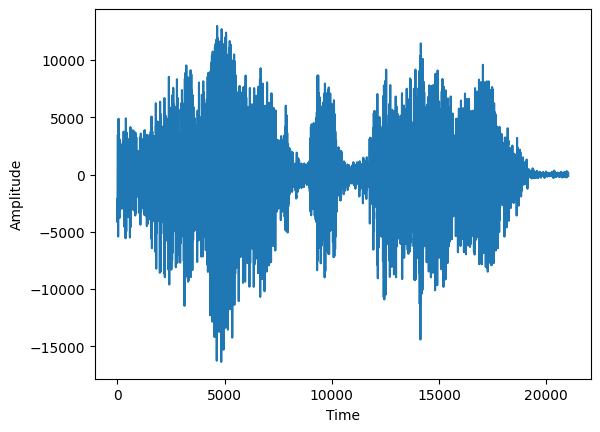

after endpoint detect moaning sound wavform


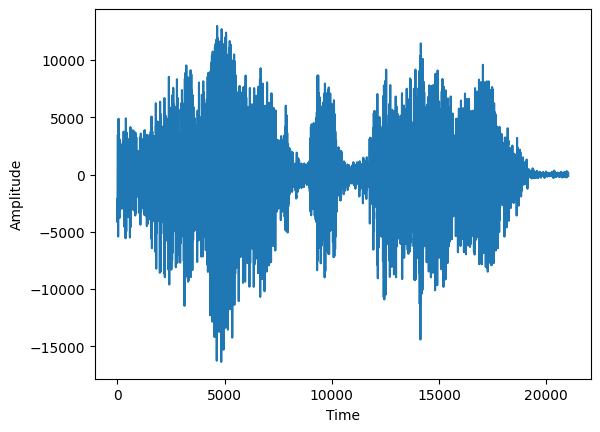

<<Before endpoint detection result:>>
the largest value index is:1
ALL Prediction Result: [[6.48550515e-04 8.86506915e-01 1.10777013e-03 1.11736745e-01]]
<<After endpoint detection result:>>
the largest value index is:1
ALL Prediction Result: [[6.48550515e-04 8.86506915e-01 1.10777013e-03 1.11736745e-01]]
ground_truth:1 || original moaning predict:1 || endpoint-detect moaning predict:1


In [26]:
# test_moaning_file = "../../../datasets/CurrentUse/wav_files/Single_Fold/val/positive/moaning_56/woman_moaning_of_pain_31_1.wav"
test_unseen_moaning_file = "../../test_sounds/test_moaning_sounds_20240705/no_head_silence/test_man_moaning_dwn001_3_56.wav";
test_moaning_with_endpoint1(moaning_wav_file=test_unseen_moaning_file)

## test alarm

In [41]:
def test_alarm_with_endpoint1(alarm_wav_file=None):
    ground_truth = 0;
    src_counter = 0;
    trimmed_counter = 0;
    src_head_silence_sig = wavio.read(alarm_wav_file).data.T[0]; #read original wav file
    print("original moaning sound wavform")
    IPython.display.display(Audio(src_head_silence_sig,rate=20000))
    plot_wav(src_head_silence_sig)
    trim_start_pos = endpoint_detection1(src_head_silence_sig,test_seg_len=200);
    src_head_silence_sig_f32 =  src_head_silence_sig.astype(np.float32);
    trimmed_wav_sig = src_head_silence_sig_f32[trim_start_pos:];
    padding_len = len(src_head_silence_sig_f32) - len(trimmed_wav_sig)
    trimmed_wav_sig = padding_sig(trimmed_wav_sig, padding_len)
    print("after endpoint detect moaning sound wavform")
    IPython.display.display(Audio(trimmed_wav_sig,rate=20000))
    plot_wav(trimmed_wav_sig)
    print("<<Before endpoint detection result:>>")
    src_output = doSoundClassification(sound=src_head_silence_sig_f32, lblidx=ground_truth, channelIdx=0,ifSrc=1);
    print("======================================================================================")
    print("<<After endpoint detection result:>>")
    trimmed_output = doSoundClassification(sound=trimmed_wav_sig, lblidx=ground_truth, channelIdx=0, ifSrc=2);
    print("======================================================================================")
    print(f"ground_truth:{ground_truth} || original alarm predict:{src_output} || endpoint-detect alarm predict:{trimmed_output}");

In [48]:
test_alarmsounds_with_headsilence_dir = "../../test_sounds/test_moaning_sounds_20240705/alarm/with_headsilence/"
# test_moaning_sounds_set2_noheadsilence_dir = "../../test_sounds/test_moaning_sounds_20240705/no_head_silence/"
alarm_sounds_headsilence_list = getFileList(test_alarmsounds_with_headsilence_dir)
# moaning_sounds_noheadsilence_list = getFileList(test_moaning_sounds_set2_noheadsilence_dir)

In [50]:
# for w in alarm_sounds_headsilence_list:
#     print(w)
"""
../../test_sounds/test_moaning_sounds_20240705/alarm/with_headsilence/test_alarm_05.wav (all wrong)
../../test_sounds/test_moaning_sounds_20240705/alarm/with_headsilence/test_alarm_04.wav (all right)
../../test_sounds/test_moaning_sounds_20240705/alarm/with_headsilence/test_alarm_02.wav (all right)
../../test_sounds/test_moaning_sounds_20240705/alarm/with_headsilence/test_alarm_01.wav (all right)
../../test_sounds/test_moaning_sounds_20240705/alarm/with_headsilence/test_alarm_03.wav (all wrong)
"""

'\n../../test_sounds/test_moaning_sounds_20240705/alarm/with_headsilence/test_alarm_05.wav\n../../test_sounds/test_moaning_sounds_20240705/alarm/with_headsilence/test_alarm_04.wav\n../../test_sounds/test_moaning_sounds_20240705/alarm/with_headsilence/test_alarm_02.wav\n../../test_sounds/test_moaning_sounds_20240705/alarm/with_headsilence/test_alarm_01.wav\n../../test_sounds/test_moaning_sounds_20240705/alarm/with_headsilence/test_alarm_03.wav\n'

original moaning sound wavform


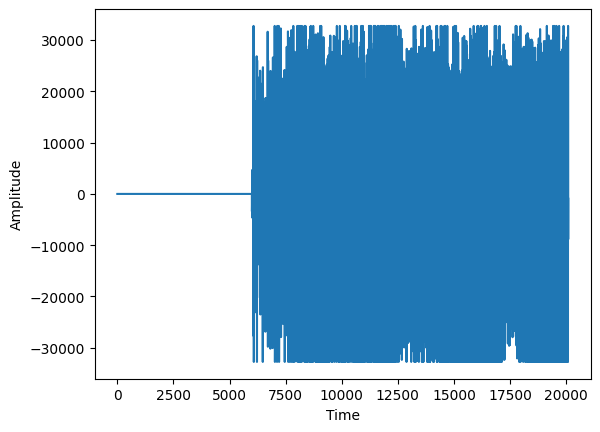

after endpoint detect moaning sound wavform


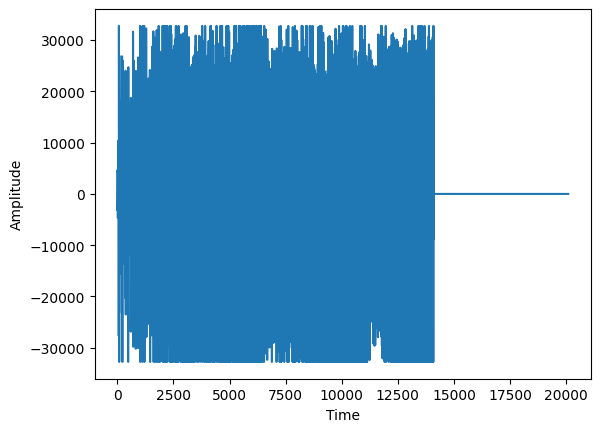

<<Before endpoint detection result:>>
the largest value index is:1
ALL Prediction Result: [[0.14021228 0.5045092  0.00117998 0.35409853]]
<<After endpoint detection result:>>
the largest value index is:3
ALL Prediction Result: [[0.39048183 0.03861731 0.00507705 0.5658238 ]]
ground_truth:0 || original moaning predict:1 || endpoint-detect moaning predict:3


In [55]:
test_val_alarm_file = "../../test_sounds/test_moaning_sounds_20240705/alarm/with_headsilence/test_alarm_03.wav";
test_alarm_with_endpoint1(alarm_wav_file=test_val_alarm_file)